In [1]:
import numpy as np
import random
import re
import requests
import pandas as pd
from datetime import datetime, timedelta
from datetime import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from ipywidgets import widgets
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.compose import ColumnTransformer


In [2]:
max_data_date = datetime(2021, 10, 7) #Last date for which we have shelter data avilable
ave_data_min = datetime(2021, 10, 7) #Date to start averaging of weather for 'future' predictions
ave_data_max = datetime(2022, 10, 7) #Date to end averaging of weather for 'future' predictions

In [3]:
#Get best weather and wind chill data (VCW_temp.csv, from Visual Crossing Weather)
df_weather = pd.read_csv("VCW_temp.csv")
df_weather.drop(['Name', 'Temperature', 'Maximum Temperature','Heat Index','Snow Depth','Wind Gust', 'Wind Direction', 'Relative Humidity'], axis=1, inplace=True)
df_weather.drop(['Visibility','Cloud Cover', 'Conditions'], axis=1, inplace=True)
df_weather['date'] = pd.to_datetime(df_weather['Date time'])
df_weather.drop(['Date time'], axis=1, inplace=True)
df_weather = df_weather[df_weather['date'] <= max_data_date]
df_weather['Wind Chill'] = df_weather['Wind Chill'].fillna(df_weather['Minimum Temperature']) #Might use Wind Chill instead
df_weather['Wind Speed'] = df_weather['Wind Speed'].fillna(0.00) #Might use Wind Chill instead
df_weather['Precipitation'] = df_weather['Precipitation'].fillna(0.0)
df_weather['Snow'] = df_weather['Snow'].fillna(0.00)
df_weather['date'] = pd.to_datetime(df_weather['date'])
df_weather['day_of_year'] = df_weather.apply(lambda row: (row.date.day_of_year), axis=1)

df_weather.head(5)

,Minimum Temperature,Wind Chill,Precipitation,Snow,Wind Speed,date,day_of_year
0,44.9,41.6,1.06,0.0,19.1,2007-01-01,1
1,38.3,34.9,0.00,0.0,24.2,2007-01-02,2
2,32.7,29.6,0.00,0.0,15.4,2007-01-03,3
3,42.2,37.8,0.00,0.0,10.5,2007-01-04,4
4,52.5,52.5,0.20,0.0,13.5,2007-01-05,5


In [4]:
#Make a section for future prediction based on average weather over past several years

df_weather_to_ave = df_weather.copy()
mask = (df_weather_to_ave['date'] >= datetime(2015, 1, 1)) & (df_weather_to_ave['date'] < max_data_date)
df_weather_to_ave = df_weather_to_ave.loc[mask]


df_ave_weather = df_weather_to_ave.copy().groupby('day_of_year').mean()


new_dates = pd.date_range(start=ave_data_min, end=ave_data_max, freq='1d')

day_column = new_dates.day_of_year
d = {'date':new_dates,'day_of_year':day_column}
df_future = pd.DataFrame(d)
df_future = df_future.merge(df_ave_weather, how='left', left_on='day_of_year', right_on='day_of_year')


df_future['Total'] = 10000 #Holder
df_future['Male'] = 100 #Holder
df_future['Female'] = 100 #Holder

df_future = df_future.dropna()


df_future.head(5)

,date,day_of_year,Minimum Temperature,Wind Chill,Precipitation,Snow,Wind Speed,Total,Male,Female
0,2021-10-07,280,60.983333,60.733333,0.003333,0.0,13.233333,10000,100,100
1,2021-10-08,281,63.683333,63.683333,0.001667,0.0,13.783333,10000,100,100
2,2021-10-09,282,64.283333,64.283333,0.220000,0.0,15.150000,10000,100,100
3,2021-10-10,283,60.316667,59.983333,0.030000,0.0,15.750000,10000,100,100
4,2021-10-11,284,58.600000,57.866667,0.241667,0.0,13.983333,10000,100,100


In [5]:
#This is a shelter we need to remove from Total, Male, and Female columns (InShelterPerDay_Gender_Shelter_10-06-2021.csv):
df_coh = pd.read_csv("InShelterPerDay_Gender_Shelter_10-06-2021.csv")
df_coh['date'] = pd.to_datetime(df_coh['date'])
df_coh = df_coh.drop(columns=['MinTempF', 'MaxTempF', 'SnowIn', 'PrecipIn', 'FreezingAtEntry', 'dayWeek', 'month', 'day', 'year'])
mask = (df_coh['name'] == 'COH - The Triumph - DHS STFH - ES FAM - DHS Direct')
df_coh = df_coh[['date','Male', 'Female','name']].loc[mask]
df_coh = df_coh.rename(columns={"Male": "Male_COH", "Female": "Female_COH"})
df_coh['Total_COH'] = df_coh['Male_COH'] + df_coh['Female_COH']
df_coh = df_coh.drop(columns=['name'])

df_ken = pd.read_csv("InShelterPerDay_Gender_Shelter_10-06-2021.csv")
df_ken['date'] = pd.to_datetime(df_ken['date'])
df_ken = df_ken.drop(columns=['MinTempF', 'MaxTempF', 'SnowIn', 'PrecipIn', 'FreezingAtEntry',  'dayWeek', 'month', 'day', 'year'])
mask = (df_ken['name'] == 'NCCF - The Kennedy - DHS STFH - ES FAM - DHS Direct')
df_ken = df_ken[['date','Male', 'Female','name']].loc[mask]
df_ken = df_ken.rename(columns={"Male": "Male_KEN", "Female": "Female_KEN"})
df_ken['Total_KEN'] = df_ken['Male_KEN'] + df_ken['Female_KEN']
df_ken = df_ken.drop(columns=['name'])


In [6]:
#Remove COH and Ken shelters from gendered data

df_use = pd.read_csv("InShelterPerDayGender-10-16-2021.csv")
df_use = df_use.drop(columns=['MinTempF', 'MaxTempF', 'SnowIn', 'PrecipIn', 'FreezingAtEntry', 'NA', 'Transgender', 'dayWeek', 'month', 'day', 'year'])
df_use['date'] = pd.to_datetime(df_use['date'])
df_use['Total'] = df_use['Male'] + df_use['Female']


df_use = df_use.merge(df_coh, how='left', left_on='date', right_on='date')
df_use['Total'] = df_use['Total'] - df_use['Total_COH']
df_use['Male'] = df_use['Male'] - df_use['Male_COH']
df_use['Female'] = df_use['Female'] - df_use['Female_COH']
df_use = df_use.drop(columns=['Total_COH', 'Male_COH', 'Female_COH'])

df_use = df_use.merge(df_ken, how='left', left_on='date', right_on='date')
df_use['Total'] = df_use['Total'] - df_use['Total_KEN']
df_use['Male'] = df_use['Male'] - df_use['Male_KEN']
df_use['Female'] = df_use['Female'] - df_use['Female_KEN']
df_use = df_use.drop(columns=['Total_KEN', 'Male_KEN', 'Female_KEN'])

#Add Temperature and Windchill data
df_use = df_use.merge(df_weather, how='left', left_on='date', right_on='date')
df_use['date'] = pd.to_datetime(df_use['date'])
df_use = df_use[df_use['date'] > datetime(2007, 1, 1)]
df_use = pd.concat([df_use, df_future])

df_use['day_of_week'] = df_use.apply(lambda row: int(row.date.day_of_week + 1), axis=1)
df_use['prev_min_temp'] = df_use['Minimum Temperature'].shift(1)

df_use.head(0) #display column names only

,date,Female,Male,Total,Minimum Temperature,Wind Chill,Precipitation,Snow,Wind Speed,day_of_year,day_of_week,prev_min_temp


In [7]:
#Add Homeless population data and Metrobus usage:


df_use["dc_pop"] =  "582049"
df_use.loc[df_use.date >= datetime(2004, 6, 1), "dc_pop"] = "582049"
df_use.loc[df_use.date >= datetime(2005, 6, 1), "dc_pop"] = "585171"
df_use.loc[df_use.date >= datetime(2006, 6, 1), "dc_pop"] = "588292"
df_use.loc[df_use.date >= datetime(2007, 6, 1), "dc_pop"] = "588363"
df_use.loc[df_use.date >= datetime(2008, 6, 1), "dc_pop"] = "588433"
df_use.loc[df_use.date >= datetime(2009, 6, 1), "dc_pop"] = "605125"
df_use.loc[df_use.date >= datetime(2010, 6, 1), "dc_pop"] = "619624"
df_use.loc[df_use.date >= datetime(2011, 6, 1), "dc_pop"] = "633427"
df_use.loc[df_use.date >= datetime(2012, 6, 1), "dc_pop"] = "646669"
df_use.loc[df_use.date >= datetime(2013, 6, 1), "dc_pop"] = "658893"
df_use.loc[df_use.date >= datetime(2014, 6, 1), "dc_pop"] = "672228"
df_use.loc[df_use.date >= datetime(2015, 6, 1), "dc_pop"] = "681170"
df_use.loc[df_use.date >= datetime(2016, 6, 1), "dc_pop"] = "693972"
df_use.loc[df_use.date >= datetime(2017, 6, 1), "dc_pop"] = "702455"
df_use.loc[df_use.date >= datetime(2018, 6, 1), "dc_pop"] = "705749"
df_use.loc[df_use.date >= datetime(2019, 6, 1), "dc_pop"] = "689545"
df_use.loc[df_use.date >= datetime(2020, 6, 1), "dc_pop"] = "690345"
df_use["dc_pop"] = pd.to_numeric(df_use["dc_pop"])


df_use["homeless_pop"] = "3200"
df_use.loc[df_use.date >= datetime(2011, 1, 21), "homeless_pop"] = 3228
df_use.loc[df_use.date >= datetime(2012, 1, 21), "homeless_pop"] = 3233
df_use.loc[df_use.date >= datetime(2013, 1, 21), "homeless_pop"] = 3128
df_use.loc[df_use.date >= datetime(2014, 4, 21), "homeless_pop"] = 3072
df_use.loc[df_use.date >= datetime(2015, 4, 21), "homeless_pop"] = 2889
df_use.loc[df_use.date >= datetime(2016, 4, 21), "homeless_pop"] = 2912
df_use.loc[df_use.date >= datetime(2017, 4, 21), "homeless_pop"] = 3156
df_use.loc[df_use.date >= datetime(2018, 4, 21), "homeless_pop"] = 3224
df_use.loc[df_use.date >= datetime(2019, 4, 21), "homeless_pop"] = 2971
df_use.loc[df_use.date >= datetime(2020, 4, 21), "homeless_pop"] = 2845
df_use.loc[df_use.date >= datetime(2021, 4, 21), "homeless_pop"] = 2936
df_use["homeless_pop"] = pd.to_numeric(df_use["homeless_pop"])

df_use["MetroBus"] = "0.46" #in millions of daily rides (mid-year ave.)
df_use.loc[df_use.date >= datetime(2000, 1, 1), "MetroBus"] = "0.46"
df_use.loc[df_use.date >= datetime(2015, 1, 1), "MetroBus"] = "0.44"
df_use.loc[df_use.date >= datetime(2016, 1, 1), "MetroBus"] = "0.41"
df_use.loc[df_use.date >= datetime(2017, 1, 1), "MetroBus"] = "0.37"
df_use.loc[df_use.date >= datetime(2018, 1, 1), "MetroBus"] = "0.36"
df_use.loc[df_use.date >= datetime(2019, 1, 1), "MetroBus"] = "0.35"
df_use.loc[df_use.date >= datetime(2020, 1, 1), "MetroBus"] = "0.35"
df_use.loc[df_use.date >= datetime(2020, 3, 1), "MetroBus"] = "0.18"
df_use.loc[df_use.date >= datetime(2020, 4, 1), "MetroBus"] = "0.0"
df_use.loc[df_use.date >= datetime(2020, 5, 1), "MetroBus"] = "0.02"
df_use.loc[df_use.date >= datetime(2020, 6, 1), "MetroBus"] = "0.02"
df_use.loc[df_use.date >= datetime(2020, 7, 1), "MetroBus"] = "0.03"
df_use.loc[df_use.date >= datetime(2020, 8, 1), "MetroBus"] = "0.03"
df_use.loc[df_use.date >= datetime(2020, 9, 1), "MetroBus"] = "0.04"
df_use.loc[df_use.date >= datetime(2020, 10, 1), "MetroBus"] = "0.04"
df_use.loc[df_use.date >= datetime(2020, 11, 1), "MetroBus"] = "0.04"
df_use.loc[df_use.date >= datetime(2020, 12, 1), "MetroBus"] = "0.04"
df_use.loc[df_use.date >= datetime(2021, 1, 1), "MetroBus"] = "0.11"
df_use.loc[df_use.date >= datetime(2021, 2, 1), "MetroBus"] = "0.10"
df_use.loc[df_use.date >= datetime(2021, 3, 1), "MetroBus"] = "0.12"
df_use.loc[df_use.date >= datetime(2021, 4, 1), "MetroBus"] = "0.12"
df_use.loc[df_use.date >= datetime(2021, 5, 1), "MetroBus"] = "0.13"
df_use.loc[df_use.date >= datetime(2021, 6, 1), "MetroBus"] = "0.14"
df_use.loc[df_use.date >= datetime(2021, 7, 1), "MetroBus"] = "0.14"
df_use.loc[df_use.date >= datetime(2021, 8, 1), "MetroBus"] = "0.15"
df_use.loc[df_use.date >= datetime(2021, 9, 1), "MetroBus"] = "0.12"
df_use.loc[df_use.date >= datetime(2021, 10, 1), "MetroBus"] = "0.23"
df_use["MetroBus"] = pd.to_numeric(df_use["MetroBus"])

In [8]:
#Add annual cycles:
start = date(2005, 1, 1)
df_use['day'] = df_use.apply(lambda row: int(row.date.day), axis=1)
df_use['month'] = df_use.apply(lambda row: int(row.date.month), axis=1)
df_use['year'] = df_use.apply(lambda row: int(row.date.year), axis=1)
df_use['diff_date'] = df_use.apply(lambda row: (date(row.year, row.month, row.day) - start), axis=1)
df_use['Julian'] = pd.to_numeric(df_use['diff_date'].dt.days, downcast='integer')
df_use['cos(year)'] = np.cos(df_use['Julian'] / 365.25 * 2 * np.pi) + 5.0 #an offset cosine funtion to approximate yearly trend
df_use = df_use.drop(columns=['day', 'month', 'year', 'diff_date', 'Julian'])


In [9]:
#If the processed data will be dilled:
#import dill
#from dill import dumps, loads
#dill.dump(df_use, open('df_use.pkd', 'wb'))
#df_use = dill.load(open('df_use.pkd', 'rb'))

In [10]:
#df_use = dill.load(open('df_use.pkd', 'rb'))

In [11]:
#Same as df_use, but all weather is set to historial average for the day

df_hist = df_use.copy()
df_hist = df_hist.drop(columns=['Minimum Temperature', 'Precipitation', 'Snow', 'Wind Speed', 'prev_min_temp'])
df_hist = df_hist.merge(df_ave_weather, how='left', left_on='day_of_year', right_on='day_of_year')
df_hist['prev_min_temp'] = df_hist['Minimum Temperature'].shift(1)

df_hist.head(0) #set to display column titles only

,date,Female,Male,Total,Wind Chill_x,day_of_year,day_of_week,dc_pop,homeless_pop,MetroBus,cos(year),Minimum Temperature,Wind Chill_y,Precipitation,Snow,Wind Speed,prev_min_temp


In [12]:
def reduce_XY(time_start, time_finish, min_temp, max_temp, X_columns, Population_type, df_chosen):
    
    df_reduced = df_chosen.copy()
    leapyear_year = time_finish.year
    if leapyear_year%4 == 0:
        leap_date = datetime(leapyear_year, 2, 29)
        df_reduced = df_reduced[df_reduced['date'] != leap_date]
    df_reduced[Population_type] = df_reduced[Population_type] / df_reduced['homeless_pop']
    mask = (df_reduced['date'] >= time_start) & (df_reduced['date'] < time_finish) & (df_reduced['Minimum Temperature'] >= min_temp) & (df_reduced['Minimum Temperature'] < max_temp)
    df_reduced = df_reduced.copy().loc[mask]
    y = df_reduced.copy()[Population_type]
    df_reduced = df_reduced[X_columns]
    scale_by = df_reduced['homeless_pop'].tolist()
    
    return df_reduced['date'], y, scale_by

def reduce_dataframe(time_start, time_finish, min_temp, max_temp, X_columns, Population_type, df_chosen):
    
    df_reduced = df_chosen.copy()
    df_reduced[Population_type] = df_reduced[Population_type] / df_reduced['homeless_pop']
    mask = (df_reduced['date'] >= time_start) & (df_reduced['date'] < time_finish) & (df_reduced['Minimum Temperature'] >= min_temp) & (df_reduced['Minimum Temperature'] < max_temp)
    df_reduced = df_reduced.copy().loc[mask]
    y = df_reduced.copy()[Population_type]
    df_reduced = df_reduced[X_columns]
    scale_by = df_reduced['homeless_pop'].tolist()
    
    return df_reduced, y, scale_by


def temp_modeling(time_start, time_finish, min_temp, max_temp, X_columns, categorical_columns, numerical_columns, Population_type, df_chosen):

    X_train, y_train, scale_by = reduce_dataframe(time_start, time_finish, min_temp, max_temp, X_columns, Population_type, df_chosen)

    preplowT = ColumnTransformer([
        ('categorical', OneHotEncoder(), categorical_columns),
        ('numeric', 'passthrough', numerical_columns),
        ('standard_scaler', StandardScaler(), numerical_columns),
        ('polynomial_trans', PolynomialFeatures(1), numerical_columns)
    ])
    model_byTemp = Pipeline([
        ('features', preplowT),
        ('regressor', RandomForestRegressor(max_depth=5, random_state=42)) #max depth 10
    ])

    model = model_byTemp.fit(X_train,y_train)
    
    return model, scale_by


In [13]:
#Code for computing statistics

def compute_R2(y_pred1, y_pred2, y_true1, y_true2):
    
    y_train = []
    y_ave = 0
    for item in y_true2:
        y_train.append(item)
        y_ave += item
    for item in y_true1:
        y_train.append(item)
        y_ave += item
    y_ave = y_ave/(1.0*len(y_train))

    y_pred = []
    pred_ave =0
    for item in y_pred2:
        y_pred.append(item*1.0)
        pred_ave += item
    for item in y_pred1:
        y_pred.append(item*1.0)
        pred_ave += item
    pred_ave = pred_ave/(1.0*len(y_pred))

    diff_num = 0
    diff_denom= 0
    for i in range(0, len(y_train)):
        diff_num += (y_train[i] - y_pred[i])*(y_train[i] - y_pred[i])
        diff_denom += (y_train[i] - y_ave)*(y_train[i] - y_ave)

    R2= 1.0 - (diff_num / diff_denom)
    
    pred_diff = []
    std_diff = []
    for i in range(0,len(y_pred)):
        pred_diff.append(y_pred[i] - y_train[i])
        if y_pred[i] - y_train[i] < 200:
            std_diff.append(np.power(y_pred[i] - y_train[i],2))
        
    pred_bin = np.array(pred_diff)
    std = np.sqrt(sum(std_diff)/(1.0*len(y_pred)))

    return R2, std, y_ave, pred_ave, pred_bin

def plot_errors(showplot, name1, name2, color1, color2, y_pred_train1, y_pred_train2, y_true_train1, y_true_train2, y_pred_test1, y_pred_test2, y_true_test1, y_true_test2):

    R2_train, std_train, true_ave_train, pred_ave_train, train_bin = compute_R2(y_pred_train1, y_pred_train2, y_true_train1, y_true_train2)  
    R2_test, std_test, true_ave_test, pred_ave_test, test_bin = compute_R2(y_pred_test1, y_pred_test2, y_true_test1, y_true_test2)  
    
    print(name1, 'standard deviation =', round(std_train,2), " (calculated / true average =", round(pred_ave_train,2), "/", round(true_ave_train,2), "and R^2 =", round(R2_train,2), ")")
    print(name2, 'standard deviation =', round(std_test,2), " (calculated / true average =", round(pred_ave_test,2), "/", round(true_ave_test,2), "and R^2 =", round(R2_test,2), ")")
    
    if showplot > 0:
        fig, axs = plt.subplots(1, 2, sharex=False, sharey=False, tight_layout=True)
        # We can set the number of bins with the `bins` kwarg
        axs[0].hist(train_bin, bins=25, color=color1)
        axs[1].hist(test_bin, bins=25, color=color2)
        xlab1 = name1 + " - Actual Beds"
        xlab2 = name2 + " - Actual Beds"
        axs[0].set(xlabel=xlab1,ylabel="Number of Occurences")
        axs[1].set(xlabel=xlab2,ylabel="Number of Occurences")
        plt.show()
    
    return

In [14]:
#Define how to deal with year in advance predictions

def SeasonPredictions(winter_test_year, Population_type, Use_known_weather):


    test_start_date = datetime(winter_test_year, 8, 1)
    test_end_date = datetime(winter_test_year+1, 4, 1)
    train_start_date = max(datetime(winter_test_year-4, 8, 1), datetime(2015, 8, 1))
    if Population_type == 'Female':
        train_start_date = max(datetime(winter_test_year-4, 8, 1), datetime(2016, 8, 1))
    train_end_date = test_start_date
    train_end_date = min(test_start_date, max_data_date)

    X_columns = ['date', 'day_of_week', 'homeless_pop', 'Wind Speed', 'Minimum Temperature', 
                 'MetroBus', 'day_of_year', 'prev_min_temp', 'Snow', 'Precipitation']
    categorical_columns = ['day_of_week']
    numerical_columns = X_columns[2:]

    model_lowT, scaleby = temp_modeling(train_start_date, train_end_date, -150, 30, X_columns, categorical_columns, numerical_columns, Population_type, df_use) 
    model_midT, scaleby = temp_modeling(train_start_date, train_end_date, 30, 150, X_columns, categorical_columns, numerical_columns, Population_type, df_use) 

    if test_end_date < max_data_date:
        X_allT, y_true_allT, scale_allT = reduce_dataframe(train_start_date, test_end_date, -150,  150, X_columns, Population_type, df_use)
    else:
        X_allT, y_true_allT, scale_allT = reduce_dataframe(train_start_date, train_end_date, -150,  150, X_columns, Population_type, df_use)
        
    X_train_lowT, y_true_train_lowT, scale_by_train_lowT = reduce_dataframe(train_start_date, train_end_date, -150,  30, X_columns, Population_type, df_use)
    X_train_midT, y_true_train_midT, scale_by_train_midT = reduce_dataframe(train_start_date, train_end_date, 30,  150, X_columns, Population_type, df_use)

    if Use_known_weather == 0:
        X_test_lowT, y_true_test_lowT, scale_by_test_lowT = reduce_dataframe(test_start_date, test_end_date, -150,  30, X_columns, Population_type, df_hist)
        X_test_midT, y_true_test_midT, scale_by_test_midT = reduce_dataframe(test_start_date, test_end_date, 30,  150, X_columns, Population_type, df_hist)
    else:
        X_test_lowT, y_true_test_lowT, scale_by_test_lowT = reduce_dataframe(test_start_date, test_end_date, -150,  30, X_columns, Population_type, df_use)
        X_test_midT, y_true_test_midT, scale_by_test_midT = reduce_dataframe(test_start_date, test_end_date, 30,  150, X_columns, Population_type, df_use)


    y_predict_train_lowT = model_lowT.predict(X_train_lowT)
    y_predict_train_midT = model_midT.predict(X_train_midT)

    y_predict_test_lowT = model_lowT.predict(X_test_lowT)
    y_predict_test_midT = model_midT.predict(X_test_midT)
    
    yearly_max_lowT = max(y_predict_test_lowT*scale_by_test_lowT)
    yearly_max_midT = max(y_predict_test_midT*scale_by_test_midT)
    print('Maximum predicted shelter usage is', round(max(yearly_max_lowT, yearly_max_midT),1), ' beds')

    plt.plot(X_allT['date'], y_true_allT*scale_allT, 'o', color='b', label="Shelter Population");
    plt.plot(X_train_lowT['date'], y_predict_train_lowT*scale_by_train_lowT, 'o', color='r', label='Training prediction');
    plt.plot(X_train_midT['date'], y_predict_train_midT*scale_by_train_midT, 'o', color='r');
    plt.plot(X_test_lowT['date'], y_predict_test_lowT*scale_by_test_lowT, 'o', color='c', label='Testing prediction');
    plt.plot(X_test_midT['date'], y_predict_test_midT*scale_by_test_midT, 'o', color='c');
    plt.xlabel('Date')
    plt.ylabel('Shelter beds utilized');
    plt.legend();
    plt.show()
    
    if test_end_date < max_data_date :
        name1 = 'Trained'
        name2 = 'Predicted'
        showplot = 1
        plot_errors(showplot, name1, name2, "r", "c", y_predict_train_lowT*scale_by_train_lowT, y_predict_train_midT*scale_by_train_midT, y_true_train_lowT*scale_by_train_lowT, y_true_train_midT*scale_by_train_midT, 
                    y_predict_test_lowT*scale_by_test_lowT, y_predict_test_midT*scale_by_test_midT, y_true_test_lowT*scale_by_test_lowT, y_true_test_midT*scale_by_test_midT)



    test_start_winter = datetime(test_start_date.year, 11, 1)
    test_end_winter = datetime(test_end_date.year, 4, 1)
    prev_start_winter = datetime(test_start_date.year - 1, 11, 1)
    prev_end_winter = datetime(test_end_date.year - 1, 4, 1)

    X_prev_year, y_prev_year, scale_prev_year = reduce_XY(prev_start_winter, prev_end_winter, -150,  150, X_columns, Population_type, df_use)
    X_this_year, y_this_year, scale_this_year = reduce_XY(test_start_winter, test_end_winter, -150,  150, X_columns, Population_type, df_use)

    y_naive = y_prev_year*scale_this_year
    if Use_known_weather == 0:
        X_test_lowT, y_true_test_lowT, scale_by_test_lowT = reduce_dataframe(test_start_winter, test_end_winter, -150,  30, X_columns, Population_type, df_hist)
        X_test_midT, y_true_test_midT, scale_by_test_midT = reduce_dataframe(test_start_winter, test_end_winter, 30,  150, X_columns, Population_type, df_hist)
    else:
        X_test_lowT, y_true_test_lowT, scale_by_test_lowT = reduce_dataframe(test_start_winter, test_end_winter, -150,  30, X_columns, Population_type, df_use)
        X_test_midT, y_true_test_midT, scale_by_test_midT = reduce_dataframe(test_start_winter, test_end_winter, 30,  150, X_columns, Population_type, df_use)
    y_predict_test_lowT = model_lowT.predict(X_test_lowT)
    y_predict_test_midT = model_midT.predict(X_test_midT)
    
    if test_end_winter < max_data_date:
        plt.plot(X_this_year, y_this_year*scale_this_year, 'o', color='b', label="Winter Shelter Population");
    if test_end_winter > max_data_date:
        if test_start_winter < max_data_date:
            X_this_year, y_this_year, scale_this_year = reduce_XY(test_start_winter, max_data_date, -150,  150, X_columns, Population_type, df_use) 
            plt.plot(X_this_year, y_this_year*scale_this_year, 'o', color='b', label="Winter Shelter Population");
    plt.plot(X_test_lowT['date'], y_predict_test_lowT*scale_by_test_lowT, 'o', color='c', label='Training prediction');
    plt.plot(X_test_midT['date'], y_predict_test_midT*scale_by_test_midT, 'o', color='c');
    plt.plot(X_this_year, y_naive, 'o', color='k', label='Naive prediction');
    plt.xlabel('Date')
    plt.ylabel('Shelter beds utilized');
    plt.legend();
    plt.show()

    if test_end_date < max_data_date :

        name2 = 'Naive'
        name1 = 'Predicted'
        showplot = 1
        plot_errors(showplot, name1, name2, "c", "k",
                    y_predict_test_lowT*scale_by_test_lowT, y_predict_test_midT*scale_by_test_midT, y_true_test_lowT*scale_by_test_lowT, y_true_test_midT*scale_by_test_midT,
                   y_naive, [], y_this_year*scale_this_year, [])

    return


In [15]:
#Define short-term prediction process

def TenDayPredictions(start_year, start_month, start_day, Population_type, df_use):
    

    test_start_date = datetime(start_year, start_month, start_day)
    test_end_date = test_start_date + timedelta(days=10)
    
    prev_start_date = datetime(start_year - 1, start_month, start_day)
    prev_end_date = prev_start_date + timedelta(days=10)
    
    train_start_date = max(datetime(start_year-4, start_month, start_day), datetime(2015, 8, 1))
    if Population_type == 'Female':
        train_start_date = max(datetime(start_year-4, start_month, start_month), datetime(2016, 8, 1))
    train_end_date = test_start_date
    train_end_date = min(train_end_date, max_data_date)

    X_columns = ['date', 'day_of_week', 'homeless_pop', 'cos(year)', 'Wind Speed', 'Minimum Temperature', 
                 'MetroBus', 'day_of_year', 'prev_min_temp', 'Snow', 'Precipitation']
    categorical_columns = ['day_of_week']
    numerical_columns = X_columns[2:]

    X_allT, y_true_allT, scale_allT = reduce_dataframe(test_start_date, test_end_date, -150,  150, X_columns, Population_type, df_use)

    X_train_lowT, y_true_train_lowT, scale_by_train_lowT = reduce_dataframe(train_start_date, train_end_date, -150,  30, X_columns, Population_type, df_use)
    X_train_midT, y_true_train_midT, scale_by_train_midT = reduce_dataframe(train_start_date, train_end_date, 30,  150, X_columns, Population_type, df_use)

    X_test_lowT, y_true_test_lowT, scale_by_test_lowT = reduce_dataframe(test_start_date, test_end_date, -150,  30, X_columns, Population_type, df_use)
    X_test_midT, y_true_test_midT, scale_by_test_midT = reduce_dataframe(test_start_date, test_end_date, 30,  150, X_columns, Population_type, df_use)

    model_lowT, scaleby = temp_modeling(train_start_date, train_end_date, -150, 30, X_columns, categorical_columns, numerical_columns, Population_type, df_use) 
    model_midT, scaleby = temp_modeling(train_start_date, train_end_date, 30, 150, X_columns, categorical_columns, numerical_columns, Population_type, df_use) 

    y_predict_train_lowT = model_lowT.predict(X_train_lowT)
    y_predict_train_midT = model_midT.predict(X_train_midT)
    
    X_prev_year, y_prev_year, scale_prev_year = reduce_XY(prev_start_date, prev_end_date, -150,  150, X_columns, Population_type, df_use)
    X_this_year, y_this_year, scale_this_year = reduce_XY(test_start_date, test_end_date, -150,  150, X_columns, Population_type, df_use)
    y_naive = y_prev_year*scale_this_year


    if len(X_test_lowT) > 0:
        y_predict_test_lowT = model_lowT.predict(X_test_lowT)
    else:
        y_predict_test_lowT = []
        scale_by_test_lowT = 1
        
    y_predict_test_midT = model_midT.predict(X_test_midT)
    
    
    #fig = go.Figure()
    if test_end_date < max_data_date:
        plt.plot(X_allT['date'], y_true_allT*scale_allT, 'o', color='b', label="Shelter Population");
    elif test_end_date > max_data_date:
        if test_start_date < max_data_date:
            X_allT, y_true_allT, scale_allT = reduce_dataframe(test_start_date, max_data_date, -150,  150, X_columns, Population_type, df_use)
            plt.plot(X_allT['date'], y_true_allT*scale_allT, 'o', color='b', label="Shelter Population");

    plt.plot(X_this_year, y_naive, 'o', color='k', label="Naive Prediction");

    if len(X_test_lowT) > 0:
        plt.plot(X_test_lowT['date'], y_predict_test_lowT*scale_by_test_lowT, 'o', color='c');
    plt.plot(X_test_midT['date'], y_predict_test_midT*scale_by_test_midT, 'o', color='c', label='Model Prediction');



    plt.xlabel('Date')
    plt.ylabel('Shelter beds utilized');
    plt.legend();
    plt.show()

    name2 = 'Naive'
    name1 = "Precicted"
    showplot = 0
    if test_end_date < max_data_date:
        plot_errors(showplot, name1, name2, "c", "k",
                    y_predict_test_lowT*scale_by_test_lowT, y_predict_test_midT*scale_by_test_midT, y_true_test_lowT*scale_by_test_lowT, y_true_test_midT*scale_by_test_midT,
                     y_naive, [], y_this_year*scale_this_year, [])
        
    return


Maximum predicted shelter usage is 2061.7  beds


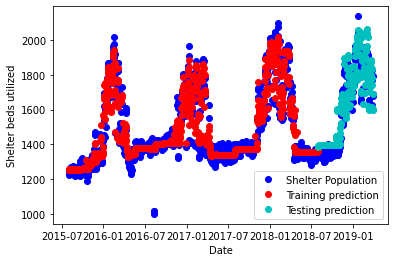

Trained standard deviation = 45.83  (calculated / true average = 1474.02 / 1474.45 and R^2 = 0.94 )
Predicted standard deviation = 79.46  (calculated / true average = 1639.2 / 1620.64 and R^2 = 0.87 )


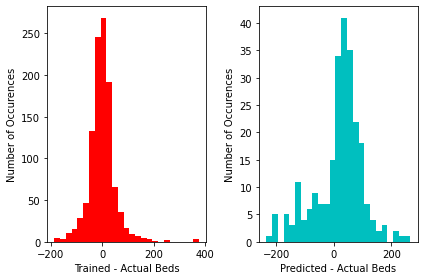

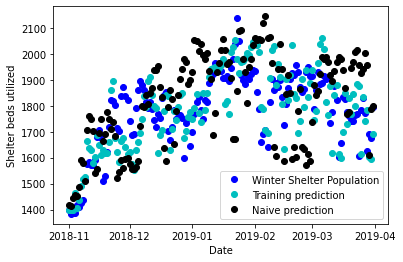

Predicted standard deviation = 93.19  (calculated / true average = 1783.56 / 1783.0 and R^2 = 0.54 )
Naive standard deviation = 141.7  (calculated / true average = 1819.15 / 1783.0 and R^2 = -0.72 )


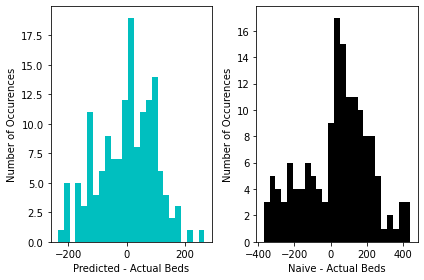

In [16]:
#Here's where users enter their choices
#Year choices: 2018, 2019, 2020, 2021
#Population choices: Total, Male, Female
winter_test_year = 2018
Population_type = 'Total'
Use_known_weather = 1 #0 means no, else yes

SeasonPredictions(winter_test_year, Population_type, Use_known_weather)


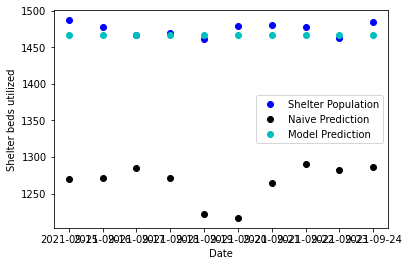

Precicted standard deviation = 12.24  (calculated / true average = 1466.15 / 1475.0 and R^2 = -1.09 )
Naive standard deviation = 210.63  (calculated / true average = 1265.83 / 1475.0 and R^2 = -618.6 )


In [17]:
#Here's where users enter their choice for 10-day predictions:
#Year choices: any date between January 2018 and Novemer 2022
Input_Year = 2021
Input_Month = 9
Input_Day = 15
#Population choices: Total, Male, Female
Input_PopulationType = 'Total'

TenDayPredictions(Input_Year, Input_Month, Input_Day, Input_PopulationType, df_use)

In [ ]:
#This next section in not on webpage, but is rather a check to see how a neural network model compares


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from numpy.random import seed

import tensorflow as tf
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Input
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_squared_error

# Generate a sample dataset from random data: 
random.seed(123)

In [30]:
df_use_nn = df_use.copy()
#df_use_nn['Total_norm'] = df_use_nn['Total'] / (df_use_nn['homeless_pop'] * df_use_nn['cos(year)'])
df_use_nn['Total_norm'] = df_use_nn['Total'] / (df_use_nn['homeless_pop'])
df_use_nn = df_use_nn.dropna()

train_start_date = datetime(2015, 8, 1) #2015
train_end_date = datetime(2018, 8, 1)
#test_end_date = test_start_date + timedelta(days=10)
mask = (df_use_nn['date'] >= train_start_date) & (df_use_nn['date'] < train_end_date)
df_train = df_use_nn.copy().loc[mask]
df_train = df_train.reset_index()

test_start_date = datetime(2018, 8, 1)
test_end_date = datetime(2021, 4, 1)
mask2 = (df_use_nn['date'] >= test_start_date) & (df_use_nn['date'] < test_end_date)
df_test = df_use_nn.copy().loc[mask2]
df_test = df_test.reset_index()


In [31]:
#variables = ['Wind Chill', 'prev_min_temp', 'day_of_year', 'Minimum Temperature']
variables = ['Wind Speed', 'prev_min_temp', 'MetroBus', 'Minimum Temperature', 'day_of_year', 'Snow', 'cos(year)']

X_test = df_test.copy()[variables]
y_test =  df_test.copy()['Total_norm']
#scale_test = df_test.copy()['homeless_pop'] * df_test.copy()['cos(year)']
scale_test = df_test.copy()['homeless_pop']

X_train = df_train.copy()[variables]
y_train =  df_train.copy()['Total_norm']
#scale_train = df_train.copy()['homeless_pop'] * df_test.copy()['cos(year)']
scale_train = df_train.copy()['homeless_pop']


In [32]:
scaler = StandardScaler()

for var in variables:
    X_train[var] = X_train[var].astype('float64')
    X_train[var] = scaler.fit_transform(X_train[var].values.reshape(-1, 1))
    
    X_test[var] = X_test[var].astype('float64')
    X_test[var] = scaler.fit_transform(X_test[var].values.reshape(-1, 1))


In [33]:
import tensorflow as tf

from numpy.random import seed
seed(42)

tf.random.set_seed(42)

def compute_R2(y_pred, y_true):
    
    y_ave = 0
    for item in y_true:
        y_ave += item
    y_ave = y_ave/(1.0*len(y_train))

    diff_num = 0
    diff_denom= 0
    for i in range(0, len(y_true)):
        diff_num += (y_true[i] - y_pred[i])*(y_true[i] - y_pred[i])
        diff_denom += (y_true[i] - y_ave)*(y_true[i] - y_ave)

    R2= 1.0 - (diff_num / diff_denom)
    
    pred_diff = []
    std_diff = []
    for i in range(0,len(y_pred)):
        pred_diff.append(y_pred[i] - y_true[i])
        std_diff.append(np.power(y_pred[i] - y_true[i],2))
        
    pred_bin = np.array(pred_diff)
    std = np.sqrt(sum(std_diff)/(1.0*len(y_pred)))

    return R2, std, y_ave, pred_bin

In [55]:
# Define and build a Sequential model, and print a summary:
def BuildModelB():
 model = Sequential()
 model.add(Dense(1024, input_dim=7, activation='relu'))
 model.add(Dense(512, activation='relu'))
 model.add(Dense(128, activation='relu')) 
 model.add(Dense(32, activation='relu')) 
 model.add(Dense(8,activation='relu')) 
 model.add(Dense(1,activation='linear'))
 model.compile(loss="mean_squared_error", optimizer="adam")   
 return model

BuildModelB().summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_72 (Dense)            (None, 1024)              8192      
                                                                 
 dense_73 (Dense)            (None, 512)               524800    
                                                                 
 dense_74 (Dense)            (None, 128)               65664     
                                                                 
 dense_75 (Dense)            (None, 32)                4128      
                                                                 
 dense_76 (Dense)            (None, 8)                 264       
                                                                 
 dense_77 (Dense)            (None, 1)                 9         
                                                                 
Total params: 603,057
Trainable params: 603,057
Non-t

In [56]:
# Fit the Sequential model with Scikit-learn Regressor API for Keras:
regressor = KerasRegressor(build_fn=BuildModelB,nb_epoch=500,batch_size=3)
regressor.fit(X_train,y_train) 

C:\Users\klkry\AppData\Local\Temp/ipykernel_20368/2435114746.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  regressor = KerasRegressor(build_fn=BuildModelB,nb_epoch=500,batch_size=3)


366/366 [==============================] - 4s 8ms/step - loss: 0.0090


0.0016256618351157917


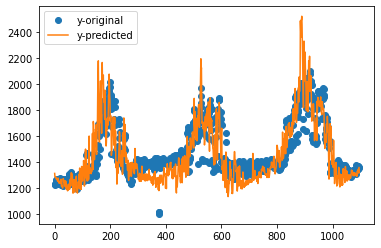

In [57]:
y_pred = regressor.predict(X_train)
mse_krr = mean_squared_error(y_train, y_pred)
print(mse_krr)

y_pred_trainB = scale_train*y_pred
y_trainB = scale_train*np.array(y_train)

plt.plot(y_trainB, 'o', label="y-original")
plt.plot(y_pred_trainB, label="y-predicted")
plt.legend()
plt.show()


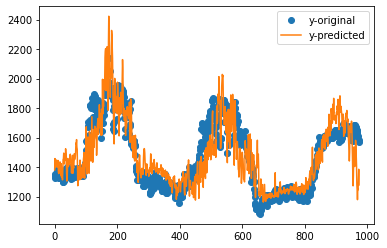

0.7922112753394839 128.74410800887117


In [58]:
y_predB = regressor.predict(X_test)
y_pred_testB = scale_test*y_predB
y_testB = scale_test*np.array(y_test)

plt.plot(y_testB, 'o', label="y-original")
plt.plot(y_pred_testB, label="y-predicted")
plt.legend()
plt.show()

R2, std, y_ave, pred_bin = compute_R2(y_pred_testB, y_testB)
print(R2, std)


In [ ]:
#The high-usage days needs to be adjusted downward...

In [59]:
#Precursor for getting updated 7-day forecast

In [62]:
import json

url = requests.get("https://api.weather.gov/gridpoints/LWX/95,70/forecast") #DC
#url = requests.get("https://api.weather.gov/gridpoints/LWX/90,78/forecast") #Rockville
print(url)
#text = url.text
#data = url.json()
data = json.loads(url.text)

for entry in data['properties']['periods']:
    print(entry['number'])
    print(entry['startTime'])
    print('Temperature in F', entry['temperature'])
    print('Wind speed in mph', entry['windSpeed'])
    precip = 'none'
    if 'precipitation' in entry['detailedForecast']:
        precip = 'possible'
    print('Precipitation', precip)
    print('')

<Response [200]>
1
2022-01-12T16:00:00-05:00
Temperature in F 47
Wind speed in mph 8 mph
Precipitation none

2
2022-01-12T18:00:00-05:00
Temperature in F 31
Wind speed in mph 0 to 7 mph
Precipitation none

3
2022-01-13T06:00:00-05:00
Temperature in F 48
Wind speed in mph 2 mph
Precipitation none

4
2022-01-13T18:00:00-05:00
Temperature in F 34
Wind speed in mph 1 to 6 mph
Precipitation none

5
2022-01-14T06:00:00-05:00
Temperature in F 44
Wind speed in mph 6 to 15 mph
Precipitation none

6
2022-01-14T18:00:00-05:00
Temperature in F 18
Wind speed in mph 8 to 12 mph
Precipitation none

7
2022-01-15T06:00:00-05:00
Temperature in F 28
Wind speed in mph 8 mph
Precipitation none

8
2022-01-15T18:00:00-05:00
Temperature in F 18
Wind speed in mph 6 mph
Precipitation none

9
2022-01-16T06:00:00-05:00
Temperature in F 39
Wind speed in mph 5 to 9 mph
Precipitation possible

10
2022-01-16T18:00:00-05:00
Temperature in F 30
Wind speed in mph 10 mph
Precipitation possible

11
2022-01-17T06:00:00-05: